# Week 4 - Logistic Regression, Feature Scaling

#### <font color='plum'> RESPONSES IN THIS COLOR

For Week 4, include concepts such as logistic regression and feature scaling.

# Imports

In [189]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import kagglehub 
import time
# from sklearn.experimental import enable_halving_search_cv  # Needed to enable
from sklearn.linear_model import LogisticRegression

# from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    RepeatedStratifiedKFold, 
    GridSearchCV, 
    # HalvingGridSearchCV,
    RandomizedSearchCV, 
    RepeatedKFold, 
    cross_val_predict, 
    cross_validate, 
    StratifiedKFold, 
    KFold
)

# # explicitly require this experimental feature
# from sklearn.experimental import enable_halving_search_cv # noqa
# # now you can import normally from model_selection
# from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    root_mean_squared_error,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score, 
    make_scorer, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_recall_curve,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from datetime         import datetime, timedelta
from tqdm             import tqdm
from typing import Any, Dict, List, Union, Tuple
from sklearn.base import BaseEstimator
from collections import Counter
from scipy.stats import randint
# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


%matplotlib inline

from kagglehub              import KaggleDatasetAdapter

sns.set_theme(font_scale=0.8) 
# plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

# Utility Functions

In [190]:
# globals
random_state    = 42
test_size       = 0.2
n_jobs          = -1
font_size       = 8

In [191]:
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

#### reorder_columns

In [192]:
def reorder_columns(df: pd.DataFrame, col_names: list) -> pd.DataFrame:
    missing_columns = set(col_names) - set(df.columns)
    # if missing_columns:
    #     raise ValueError(f"Missing columns: {missing_columns}")
    
    for col in missing_columns:
        df[col] = np.nan

    df = df[col_names]
    return df

#### null counts

In [193]:
def show_null_counts_features(df: pd.DataFrame) -> pd.DataFrame:
    """
        Identifies and summarizes columns with missing values in given dataframe .

        Steps performed:
            1. Count Null Values: Calculates the total number of null values in each column.
            2. Calculate Null Percentage: Computes the percentage of null values for each column, rounded to two decimal places.
            3. Determine Feature Types: Identifies whether each column is numeric or categorical based on its data type.
            4. Filter and Sort Columns: Filters out columns without missing values and sorts the remaining columns in descending order of their null percentage.
            5. Display Summary: Prints the total number of samples in the dataset. If there are no null values, it informs the user. Otherwise, it prints a table summarizing the columns with missing values, including the feature name, number of null values, null percentage, and feature type.

        Parameters:
            df (pd.DataFrame): The DataFrame to analyze.

        Returns:
            pd.DataFrame: A DataFrame containing the columns with missing values, along with their null counts, null percentages, and feature types.
    """
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:,.2f}%   {row['Type']}")

    return missing_data

#### plot_roc_auc_curve

In [194]:

def plot_roc_auc_curve(classifier, X_test, y_test, title='ROC AUC Curve', ax=None):
    y_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.tight_layout()
    return ax



#### plot_precision_recall_curve

In [195]:


def plot_precision_recall_curve(classifier, X_test, y_test, title='Precision-Recall Curve', ax=None):
    # Get predicted probabilities for the positive class
    y_proba = classifier.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall pairs and average precision score
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Plot the precision-recall curve
    ax.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower left")
    plt.tight_layout()
    
    return ax


#### plot_confusion_matrix

In [196]:

def plot_confusion_matrix(y_true, y_pred, model_name, labels, ax = None):
    font_size = 10
    plt.rcParams.update({"font.size": font_size})
    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax,
                xticklabels=labels, yticklabels=labels)

    # Add TP, TN, FP, FN labels
    height, width = cm.shape
    label_matrix = [["TN", "FP"], ["FN", "TP"]]
    for i in range(height):
        for j in range(width):
            ax.text(j + 0.5, i + 0.7, f"\n{label_matrix[i][j]}", 
                    ha='center', va='center', color='white', fontsize=8, fontweight='bold')

    ax.set_title(f"Confusion Matrix - {model_name}\n {labels}")
    ax.set_xlabel("Predicted", fontsize=font_size)
    ax.set_ylabel("True", fontsize=font_size)
    plt.tight_layout()
    return ax




#### plot_feature_importance

In [197]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, title="Feature Importance", color="midnightblue", ax=None, logistic=True):
    """
    Plots a horizontal bar chart of feature coefficients from a fitted Logistic Regression model,
    sorted by absolute value (most important features at the top).

        Parameters:
            - model: A fitted estimator (LogisticRegression in this case).
            - feature_names: List or Index of feature names.
            - title: str, title of the plot.
            - color: str, color of the bars.
            - ax: matplotlib Axes object, optional.
            - logistic: bool, True to plot coefficients (default for LR).
    """
    # NOTE: Adapted from the user's generic function to work with the current script's 'model' object
    
    if logistic:
        # Check if model has coef_ attribute
        if not hasattr(model, "coef_"):
            raise AttributeError("The model does not have 'coef_' attribute required for logistic regression.")
        
        # Extract and sort coefficients by absolute value
        coefficients = model.coef_[0]
        sorted_indices = np.argsort(np.abs(coefficients))[::-1]
        sorted_features = np.array(feature_names)[sorted_indices]
        sorted_importances = coefficients[sorted_indices]

        # Determine colors based on sign (positive/negative impact on diabetes)
        bar_colors = np.where(sorted_importances > 0, 'darkred', 'darkblue')
        plot_color = bar_colors
        x_label = "Standardized Coefficient (Log Odds)"
        
    elif hasattr(model, "feature_importances_"):
        # Path for feature_importances_ (not used for LR, but kept for future proofing)
        importances = model.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]
        sorted_features = np.array(feature_names)[sorted_indices]
        sorted_importances = importances[sorted_indices]
        plot_color = color
        x_label = "Importance"
    else:
        raise AttributeError("The model does not have 'coef_' or 'feature_importances_' attribute.")


    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.barh(sorted_features, sorted_importances, color=plot_color)
    ax.invert_yaxis()  # Most important features at the top
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.grid(axis='x', linestyle='--', alpha=0.6)


In [198]:

# def plot_feature_importance(search, X, title="Feature Importance", color="midnightblue", ax=None):
#     """
#     Plots a horizontal bar chart of feature importances from the best estimator in a search object,
#     sorted in descending order (most important features at the top).

#         Parameters:
#             - search: A fitted GridSearchCV or RandomizedSearchCV object with a tree-based estimator.
#             - X: pandas DataFrame of features used to train the model.
#             - title: str, title of the plot.
#             - color: str, color of the bars.
#             - ax: matplotlib Axes object, optional. If None, a new figure and axes will be created.
#     """
#     # Get  best model from the search object
#     best_model = search.best_estimator_

#     # Check if  model has feature_importances_ attribute
#     if not hasattr(best_model, "feature_importances_"):
#         raise AttributeError("The best estimator does not have 'feature_importances_' attribute.")

#     # Extract and sort feature importances
#     importances = best_model.feature_importances_
#     sorted_indices = np.argsort(importances)[::-1]
#     sorted_features = X.columns[sorted_indices]
#     sorted_importances = importances[sorted_indices]

#     # Create plot if no Axes object is provided
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(6, 4))

#     ax.barh(sorted_features, sorted_importances, color=color)
#     ax.invert_yaxis()  # Most important features at the top
#     ax.set_xlabel("Importance")
#     ax.set_title(title)

#     plt.tight_layout()
#     plt.show()


#### plot_metrics

In [199]:
def plot_metrics(param, 
                 parameter_list, 
                 cv_accuracies, 
                 train_accuracies, 
                 test_accuracies, 
                 std_cvs, 
                 best_index, 
                 model_name
                 ):
    """Plots the accuracy and standard deviation metrics."""
    plt.rcParams.update({"font.size": font_size})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 5), sharex=True)
    
    # Use only as many parameter values as computed
    partial_param_list = parameter_list[:len(cv_accuracies)]
    
    # Check if our parameter list is Boolean for proper labeling
    is_boolean      = all(isinstance(val, bool) for val in partial_param_list)
    if is_boolean: 
        # Convert booleans to integer indices for plotting
        x_vals      = list(range(len(partial_param_list)))
        x_labels    = [str(val) for val in partial_param_list]
    else:
        x_vals      = partial_param_list
        x_labels    = partial_param_list
    
    metric = 'Accuracy'

    # ----- First plot: Accuracy ----------------------------------------------------------
    ax1.set_title(f"{model_name} | {metric} vs {param}")
    
    ax1.plot(x_vals, cv_accuracies, marker = '.', label = f"CV {metric}", color = 'midnightblue')
    ax1.plot(x_vals, train_accuracies, marker = '.', label = f"Train {metric}", color = 'green')
    ax1.plot(x_vals, test_accuracies, marker = '.',  label = f"Test {metric}", color = 'orange')
    ax1.scatter([x_vals[best_index]], [cv_accuracies[best_index]], marker='x', s = 100, label = f"Best CV {metric}", color = 'red')
    
    ax1.set_ylabel(metric)
    ax1.legend()
    ax1.grid()
    
    # ----- Second plot: CV Standard Deviation ----------------------------------------------------------
    ax2.set_title(f"{model_name} | CV Standard Deviation vs {param}")
    ax2.plot(x_vals, std_cvs, marker='.', label = f"CV {metric} Std", color = 'midnightblue')
    ax2.set_xlabel(param)
    ax2.set_ylabel("Standard Deviation")
    ax2.legend()
    ax2.grid(alpha = 0.5)
    
    # If using boolean x-values, set custom ticks
    if is_boolean:
        ax2.set_xticks(x_vals)
        ax2.set_xticklabels(x_labels)
    
    plt.tight_layout()
    plt.show()


#### check_early_stopping

In [200]:
def check_early_stopping(mean_cv_accuracy, best_accuracy, no_improve_count, delta, n_iter_no_change):
    """Checks if early stopping criteria are met."""
    if mean_cv_accuracy > best_accuracy + delta:
        best_accuracy = mean_cv_accuracy
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
        print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
        return True, best_accuracy, no_improve_count
    
    return False, best_accuracy, no_improve_count

#### get_parameter_list

In [201]:
def get_parameter_list(parameter: str,  
                       custom_list: list, 
                       df: pd.DataFrame
                       ):
    
    """
    Returns a list of parameter values based on the given parameter name, using a dictionary.

        Args:
            parameter: name of the parameter.
            custom_list: Optional list of custom values, which will override the values in parameter_dict.
            df: Optional DataFrame, used for calculating total features for 'max_features'.

        Returns:
            A list of parameter values.
    """

    parameter_dict = {
        'n_estimators': list(np.arange(50, 1001, 50)),
        'max_samples': [1.0],
        'max_depth': [None] + list(np.arange(2, 17, 2)),
        'bootstrap': [True, False],
        'learning_rate': list(np.arange(.01, .50, .05)),
        'min_samples_size': list(np.arange(1, 11)),
        'min_samples_leaf': list(np.arange(1, 11))
    }

    if custom_list is not None:
        parameter_dict[parameter] = custom_list

    if parameter == 'max_features':
        if df is None:
            raise ValueError("DataFrame 'df' is required to calculate 'max_features'.")
        if parameter_dict.get('max_features') is not None:
            return parameter_dict['max_features']
        else:
            total_features = df.shape[1]
            return list(range(2, total_features)) # or list(range(18, total_features+1)), or any other range you wish.
    
    elif parameter in parameter_dict:
        return parameter_dict[parameter]
    
    else:
        return []
    

#### get_classification_labels

In [202]:
def get_classification_labels(dictionary): 
    """
    Returns the classification labels from a dictionary of outcomes--assumes the values are strings.
    """
    
    return [v for v in dictionary.items()]

#### sweep_parameter

In [204]:
def sweep_parameter(model,
                    Parameters:     dict,
                    param:          str,
                    parameter_list: list,
                    X_train:        np.ndarray,
                    y_train:        np.ndarray,
                    X_test:         np.ndarray,
                    y_test:         np.ndarray,
                    verbose          = True,
                    show_rmse        = False,
                    show_accuracy    = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10,
                    cv_folds         = 5,
                    classification_dict = None
                    ) -> Dict[str, Any]:

    """
        Sweeps a specified parameter of a Classification machine learning model and evaluates performance metrics.

            Arguments:
                - model:            The machine learning model or model class to be used.
                - Parameters:       Dictionary of model parameters.
                - param:            The parameter to sweep.
                - parameter_list:   List of values to test for the specified parameter.
                - X_train:          Training feature set.
                - y_train:          Training target set.
                - X_test:           Testing feature set.
                - y_test:           Testing target set.
                - verbose:          If True, prints detailed output and plots results (default is True).
                - show_rmse:        If True, shows RMSE instead of MSE (default is True).
                - n_iter_no_change: Number of iterations with no improvement to trigger early stopping (default is None).
                - delta:            Minimum change in MSE to qualify as an improvement (default is 0.001).
                - n_jobs:           Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
                - n_repeats:        Number of repeats for cross-validation (default is 10).
                - cv_folds:         Number of k cross-validation folds (default is 5).
                - classification_dict: Dictionary for classification labels (default is None).

            Returns:
                - Parameters: Updated dictionary of model parameters with the best parameter value found and additional information.
    """

    decimals                = 4
    start                   = time.time()
    Parameters              = Parameters.copy()  # Avoid modifying the original dictionary

    print(f"Running {model.__name__} with {param} sweep...\n")

    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count        = 0
    best_accuracy           = -np.inf  # since higher accuracy is better
    best_test_preds         = None # To store best predictions for confusion matrix

    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc = f"Sweeping {param}"):
        Parameters[param]   = p
        P_temp              = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)

        # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy, iterations, cv_folds = run_model(
            model               = model,
            show_accuracy       = show_accuracy,
            X_train             = X_train,
            y_train             = y_train,
            X_test              = X_test,
            y_test              = y_test,
            n_repeats           = n_repeats,
            cv_folds            = cv_folds,
            n_jobs              = n_jobs,
            exp_factor          = 0.5 if show_rmse else 1,
            classification_dict = classification_dict,
            **P_temp
        )
        print(f"{param} = {p}: CV_mean_accuracy = {mean_cv_accuracy:,.{decimals}f}, Train_accuracy = {train_accuracy:,.{decimals}f}, Test_accuracy = {test_accuracy:,.{decimals}f}")

        cv_accuracies.append(mean_cv_accuracy)
        std_cvs.append(std_cv_accuracy)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

       # Early-stopping logic: maximize accuracy
        if mean_cv_accuracy > best_accuracy + delta:
            best_accuracy       = mean_cv_accuracy
            no_improve_count    = 0

            # Get test predictions for best model
            model_instance      = model(**P_temp) # Instantiate with current best params
            model_instance.fit(X_train, y_train)  # Fit the model with the best parameters
            best_test_preds     = model_instance.predict(X_test)
        else:
            no_improve_count    += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    max_cv_accuracy                 = max(cv_accuracies)
    max_index                       = cv_accuracies.index(max_cv_accuracy)
    best_param                      = parameter_list[max_index]
    
    Parameters['Test_Param']        = param
    Parameters[param]               = best_param
    Parameters['Model']             = model.__name__

    Parameters['Best_CV_Accuracy']  = round(max_cv_accuracy, decimals)
    Parameters['Test_Accuracy']     = round(test_accuracies[max_index], decimals)

    Parameters['n_repeats']         = n_repeats
    Parameters['cv_folds']          = cv_folds

    end                             = time.time()
    execution_time                  = format_hms(end - start)
    Parameters['execution_time']    = execution_time
    timestamp                       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    Parameters['timestamp']         = timestamp

#### GENERATE PLOTS #####
    if verbose:
        plot_metrics(param, parameter_list, cv_accuracies, train_accuracies, test_accuracies, std_cvs, max_index, Parameters['Model'])

        print(f"\nBest {param} found: {best_param}")
        print(f"Best_CV_Accuracy: {max_cv_accuracy:,.{decimals}f}")
        print(f"Test_Accuracy: {round(test_accuracies[max_index], decimals)}")
        
        print("Classification Report:-----------------\n", classification_report(y_test, best_test_preds))
        # Plot CONFUSION MATRIX for best model ############################
        # if show_accuracy and best_test_preds is not None:
        #     fig, ax     = plt.subplots()
            
        #     class_names = get_classification_labels(classification_dict)

        #     plot_confusion_matrix(y_test, best_test_preds, Parameters['Model'], class_names, Parameters['Test_Param'],  ax = ax)
        #     plt.show()

    # Print timestamp and run-time of successful execution
    print(f'Execution time: {execution_time}')
    print("Execute successfully at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end)))

    return Parameters

#### run_GridSearch_RandomizedSearch_CV

In [205]:
# # explicitly require this experimental feature
# from sklearn.experimental import enable_halving_search_cv # noqa
# from sklearn.model_selection import HalvingGridSearchCV

def run_GridSearch_RandomizedSearch_CV(
        ensemble_model,
        dataset_name: str,
        parameter_grid: dict,
        X: pd.DataFrame,
        X_train,
        y_train,
        X_test,
        y_test,
        classification_dict: dict,
        CV_tuning_strategy: int = 0,  # 0=Randomized, 1=HalvingGrid, 2=Grid
        is_classifier: bool = True,
        iterations: int = 10,
        n_jobs: int = -1,
        verbose: bool = True,
        n_repeats: int = 10,
        cv_folds: int = 5,
        random_state: int = None,
        scoring_metric: str = 'accuracy',
        halving_factor: int = 2
    ) -> tuple:

    if isinstance(ensemble_model, type):
        model = ensemble_model(random_state=random_state)
    else:
        model = ensemble_model

    model_name = model.__class__.__name__

    search_params = {
        'n_jobs':           n_jobs,
        'verbose':          verbose,
        'cv':               cv_folds,
        'scoring':          scoring_metric,
        'return_train_score': True,
        'random_state':     random_state,
        'estimator':        model
    }

    if CV_tuning_strategy == 0:
        search_type = 'RandomizedSearchCV'

        print(f"Using {search_type}...")
        search = RandomizedSearchCV(
            param_distributions = parameter_grid,
            n_iter              = iterations,
            **search_params
        )

    elif CV_tuning_strategy == 1:
        search_type = 'HalvingGridSearchCV'

        print(f"Using {search_type} with halving factor {halving_factor}...")
        search = HalvingGridSearchCV(
            param_grid          = parameter_grid,
            factor              = halving_factor,
            **search_params
        )

    else:
        if CV_tuning_strategy != 2:
            raise ValueError("CV_tuning_strategy must be 0 (Randomized), 1 (HalvingGrid), or 2 (Grid).")
        search_type = 'GridSearchCV'
        
        print(f"Using {search_type}...")
        search = GridSearchCV(
            param_grid          = parameter_grid,
            **search_params
        )
       

    start   = time.time()
    search.fit(X_train, y_train)
    end     = time.time()

    cv_results_df = pd.DataFrame(search.cv_results_)

    print(f"\nBest Parameters: {search.best_params_}")
    best_score = search.best_score_
    print(f"Best CV Score ({scoring_metric}): {best_score:,.4f}")

    y_pred      = search.best_estimator_.predict(X_test)
    test_score  = accuracy_score(y_test, y_pred, normalize = True)
    print(f"Test Accuracy: {test_score:,.4f}")

    execution_time = format_hms(end - start)
    print(f"Execution Time: {execution_time} seconds")

    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f'Completed at: {timestamp}')

    if is_classifier:
        print(f"\n{model_name} - {search_type}\nClassification Report:\n{classification_report(y_test, y_pred, digits=4)}")

        train_preds     = search.best_estimator_.predict(X_train)
        train_accuracy  = round(accuracy_score(y_train, train_preds), 4)
        print(f"Train Accuracy: {train_accuracy:,.4f}")
        print(f"Test Accuracy: {test_score:,.4f}")

        labels = [v for v in classification_dict.values()] if classification_dict else None
        fig, ax = plt.subplots(2, 2, figsize = (15, 9))
        ax      = ax.flatten()
        # title for the plots
        fig.suptitle(f"{dataset_name}\n{model_name} - {search_type}", fontsize = 12, fontweight='bold')

        plot_roc_auc_curve(search.best_estimator_, X_test, y_test, title = f'{model_name} ROC AUC Curve', ax=ax[0])
        plot_precision_recall_curve(search.best_estimator_, X_test, y_test, title = f'{model_name} Precision-Recall Curve', ax = ax[1])
        plot_confusion_matrix(y_test, y_pred, model_name, labels, ax = ax[2])
        plot_feature_importance(search, X, title = f'{model_name} Feature Importance\n{classification_dict}', color='midnightblue', ax = ax[3])

        plt.tight_layout()
        plt.show()

    best_params_df = pd.DataFrame([search.best_params_])
    best_params_df['Dataset']           = dataset_name
    best_params_df['Model']             = model_name
    best_params_df['Strategy']          = search_type
    best_params_df['Scoring_Metric']    = scoring_metric
    best_params_df['Best_CV_Score']     = best_score
    best_params_df['Test_Accuracy']     = test_score
    best_params_df['execution_time']    = execution_time
    best_params_df['timestamp']         = timestamp

    return best_params_df, cv_results_df, search


# 3. Datasets

## <font color='plum'> 3.a. Diabetes Health Indicators Dataset
Over 250,000 responses from a U.S. national health survey with demographic and lifestyle variables (e.g., BMI, activity level, smoking, sleep, general health).

Designed for predicting diabetes status (none, pre-diabetic, diabetic).
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

In [206]:
# pip install --upgrade kagglehub

### Load & Clean

In [207]:
file_path = "alexteboul/diabetes-health-indicators-dataset"
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

#diabetes_012_health_indicators_BRFSS2015.csv
#diabetes_binary_health_indicators_BRFSS2015.csv

# Load the latest version
df_3a = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)
df_3a.columns = df_3a.columns.str.strip() 
# df_3a.head(n = 10)

In [208]:
df_3a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

### Logistic Regression - Diabetes

In [209]:
target_col  = 'Diabetes_binary'
X           = df_3a.drop(columns = [target_col])
y           = df_3a[target_col]

# Identify column types based on user's logic (nunique > 2 for numeric)
numeric_cols        = []
categorical_cols    = []

# Use column names from X directly
feature_cols = X.columns.tolist()

for col in feature_cols:
    if df_3a[col].nunique() > 2:
        numeric_cols.append(col)
    else:
        # These are binary (0/1) and will be passed through without scaling
        categorical_cols.append(col)

dict_outcome = {
    0: 'No Diabetes',
    1: 'Pre-/Diabetes'
}

print("--- Feature Classification Summary ---")
print(f"Total Features: {len(feature_cols)}")
print(f"Numeric Features (to be scaled): {numeric_cols}")
print(f"Binary/Categorical Features (to be passed through): {categorical_cols}\n")

# ---Data Splitting: Create the final train/test split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = test_size, random_state = random_state, stratify = y
)
print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}\n")


# --- Manual Feature Scaling using only the training data ---

scaler = StandardScaler()

# Fit scaler ONLY on the numeric columns of the training data
X_train_numeric         = X_train[numeric_cols]
X_train_scaled_numeric  = scaler.fit_transform(X_train_numeric)

# Transform numeric columns of the test data
X_test_numeric          = X_test[numeric_cols]
X_test_scaled_numeric   = scaler.transform(X_test_numeric)

# Combine scaled numeric data with unscaled categorical data for both sets
# Training Set
X_train_scaled_df = pd.DataFrame(X_train_scaled_numeric, columns=numeric_cols, index=X_train.index)
X_train_final     = pd.concat(
    [X_train_scaled_df, X_train[categorical_cols]], axis=1
)

# Test Set
X_test_scaled_df    = pd.DataFrame(X_test_scaled_numeric, columns=numeric_cols, index=X_test.index)
X_test_final        = pd.concat(
    [X_test_scaled_df, X_test[categorical_cols]], axis=1
)


# ---Define Model and Advanced Cross-Validation Strategy ---

# Logistic Regression model (no pipeline needed since scaling is done)
model = LogisticRegression(random_state = random_state, solver = 'liblinear')

# Define repeated cross-validation strategy: 5 folds repeated 5 times (25 total fits)
N_SPLITS, N_REPEATS = 5, 5
print(f" Repeated Stratified K-Fold: {N_REPEATS} repeats of {N_SPLITS}-folds ({N_SPLITS * N_REPEATS} total fits)...")

cv = RepeatedStratifiedKFold(
    n_splits        = N_SPLITS,
    n_repeats       = N_REPEATS,
    random_state    = random_state
)

# --- Cross-Validation Evaluation on the SCALED Training Data ---
# Use scaled training data (X_train_final) for CV to tune/select the model.
print("\n Repeated Stratified Cross-Validation on Training Data...")
cv_scores = cross_val_score(
    model,
    X_train_final, # Use the SCALED training features
    y_train,
    cv      = cv,
    scoring = 'accuracy',
    n_jobs  = -1 # Use all available cores for speed
)

# print(f"Total {N_SPLITS*N_REPEATS} Individual Scores: {np.round(cv_scores, 4)}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# --- Model Training and Evaluation on  Hold-Out Test Set ---

# Train on  entire SCALED training set
print("\nTraining final model on full scaled training set...")
model.fit(X_train_final, y_train)

# Predict on  hold-out scaled test set
y_pred = model.predict(X_test_final)

accuracy    = accuracy_score(y_test, y_pred)
report      = classification_report(y_test, y_pred, target_names = dict_outcome.values())

print(f"Final Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", report)


--- Feature Classification Summary ---
Total Features: 21
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

Data Split: Training set size = 56553, Test set size = 14139

 Repeated Stratified K-Fold: 5 repeats of 5-folds (25 total fits)...

 Repeated Stratified Cross-Validation on Training Data...
Mean CV Accuracy: 0.7483
Standard Deviation: 0.0030

Training final model on full scaled training set...
Final Test Accuracy: 0.7457

Classification Report:
                precision    recall  f1-score   support

  No Diabetes       0.76      0.73      0.74      7070
Pre-/Diabetes       0.74      0.76      0.75      7069

     accuracy                           0.75     14139
    macro avg       0.75

In [210]:

# --- Feature Importance (Coefficients) ---
print("\n--- Feature Coefficients (Log Odds) ---")
# Logistic regression doesn’t have .feature_importances_. Instead, use .coef_ for feature weights.

# Combine feature names with their coefficients
feature_names   = X_train_final.columns.tolist()
coefficients    = model.coef_[0]


coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value (highest influence first)
coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("Coefficients sorted by absolute magnitude (highest influence first):")
# print(coef_df[['Feature', 'Coefficient']].to_string(index=False))
coef_df


--- Feature Coefficients (Log Odds) ---
Coefficients sorted by absolute magnitude (highest influence first):


,Feature,Coefficient,Absolute_Coefficient
9,CholCheck,1.314320,1.314320
16,HvyAlcoholConsump,-0.750749,0.750749
7,HighBP,0.729718,0.729718
1,GenHlth,0.661698,0.661698
8,HighChol,0.589994,0.589994
0,BMI,0.540430,0.540430
4,Age,0.430153,0.430153
20,Sex,0.270649,0.270649
12,HeartDiseaseorAttack,0.264727,0.264727
11,Stroke,0.184323,0.184323


 - The features were scaled (standardized), so coefficients are directly comparable.
 - A positive coefficient means an increase in that feature is associated with a higher likelihood of Pre-/Diabetes (1).
 - A negative coefficient means an increase in that feature is associated with a lower likelihood of Pre-/Diabetes (1).
 - The magnitude (absolute value) indicates the feature's relative predictive power.


--- Generating Model Visualization Grid ---


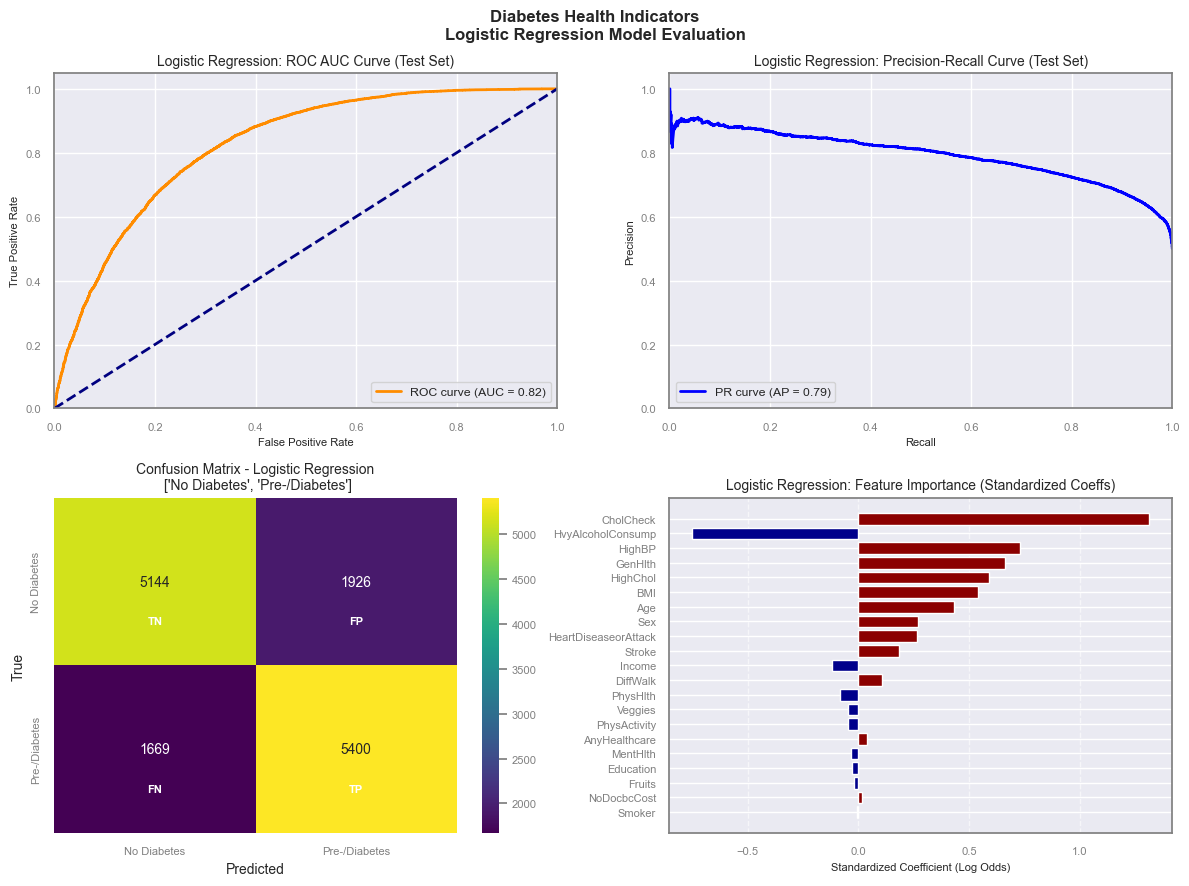

In [211]:
# --- Model Visualization (2x2 Grid) ---

print("\n--- Generating Model Visualization Grid ---")
model_name      = "Logistic Regression"
dataset_name    = "Diabetes Health Indicators"
labels          = list(dict_outcome.values())

fig, ax = plt.subplots(2, 2, figsize = (12, 9))
ax      = ax.flatten()

fig.suptitle(f"{dataset_name}\n{model_name} Model Evaluation", fontsize = 12, fontweight = 'bold')

# --- Plot 1: ROC AUC Curve ---
plot_roc_auc_curve(
    model, 
    X_test_final, 
    y_test, 
    title   = f'{model_name}: ROC AUC Curve (Test Set)', 
    ax      = ax[0]
)

# --- Plot 2: Precision-Recall Curve ---
plot_precision_recall_curve(
    model, 
    X_test_final, 
    y_test, 
    title   = f'{model_name}: Precision-Recall Curve (Test Set)', 
    ax      = ax[1]
)

# --- Plot 3: Confusion Matrix ---
plot_confusion_matrix(
    y_test, 
    y_pred, 
    model_name, 
    labels, 
    # title=f'{model_name} Confusion Matrix (Test Set)', 
    ax = ax[2]
)

# --- Plot 4: Feature Importance (Coefficients) ---
plot_feature_importance(
    model,
    feature_names = X_train_final.columns,
    title = f'{model_name}: Feature Importance (Standardized Coeffs)',
    ax = ax[3]
)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
plt.tight_layout()
plt.show()


In [212]:
# cv_results_df

In [213]:
# show features and feature importances
# feature_importances = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': search.best_estimator_.feature_importances_
# }).sort_values(by='Importance', ascending=False)

# feature_importances

### GridSearchCV

In [214]:

param_grid = {
    'C':        [0.01, 0.1, 1, 10, 100],
    'penalty':  ['l1', 'l2'],
    'solver':   ['liblinear']  # 'liblinear' supports both l1 and l2
}

model = LogisticRegression(random_state = random_state, solver = 'liblinear')
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1', n_jobs = -1, verbose = 2)
grid_search.fit(X_train_final, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ................C=0.1, penalty=l2, solv

In [218]:
##### SUMMARY ######
# combine best_params_df and best_params_df_grid into a single DataFrame
# summary_df = pd.concat([best_params_df, best_params_df_grid], ignore_index=True)
# summary_df['CV_Tuning_Strategy'] = ['RandomizedSearchCV', 'HalvingGridSearchCV']
# summary_df = summary_df[['Model', 'Test_Param', 'Best_CV_Accuracy', 'Test_Accuracy', 'execution_time', 'timestamp', 'CV_Tuning_Strategy']]



##  <font color='plum'> 3.b. Hypertension Risk Prediction Dataset

Includes lifestyle, demographic, and clinical data (e.g., BMI, cholesterol, stress,
salt intake, smoking, family history) from individuals across multiple countries. It is
labeled for classification tasks (low vs. high risk of hypertension).
https://www.kaggle.com/datasets/ankushpanday1/hypertension-risk-prediction-dataset

## <font color='plum'> 3.c. Chronic Kidney Disease Dataset

Contains comprehensive data for 1,659 patients, including 54 variables spanning medical history, lab results, medication usage, quality of life, and environmental
exposure. Ideal for regression, classification, and clustering analyses.
https://www.kaggle.com/datasets/rabieelkharoua/chronic-kidney-disease-dataset-analysis

### Load & Clean - CKD

In [230]:
file_path = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
file_name = "Chronic_Kidney_Dsease_data.csv"

# Load the latest version
df_3c = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)

# Custom preprocessing steps from the user's request
df_3c.columns       = df_3c.columns.str.strip()
columns_to_drop     = ['PatientID', 'DoctorInCharge']  # Columns to drop
df_3c.drop(columns = columns_to_drop, 
           inplace = True, 
           errors  = 'ignore'
           )  # Drop specified columns

target_col          = 'Diagnosis'
categorical_cols    = []
numeric_cols        = []
random_state        = 42
test_size           = 0.2

X_df = df_3c.drop(columns = [target_col])
for col in X_df:
    if len(X_df[col].unique()) < 5:
        categorical_cols.append(col);
    else:
        numeric_cols.append(col);
    # print(f'{col}: {X_df[col].nunique()} unique values\n')

print(f"\nCategorical columns identified (unique < 5): {categorical_cols}")
print(f"Numeric columns identified (unique >= 5): {numeric_cols}")
print(f'# Categorical cols: {len(categorical_cols)}, # Numeric cols: {len(numeric_cols)}')

# Specific categorical columns for one-hot encoding
categorical_cols_nominal = ['Ethnicity','SocioeconomicStatus', 'EducationLevel']

# --- 2. Data Transformation (Cleaning, Encoding, and Imputation) ---
data = df_3c.copy()

# A. Convert target to numeric (assuming Diagnosis is CKD_NO=0, CKD_YES=1)
data[target_col] = data[target_col].astype(int) 
print(f"\nTarget column '{target_col}' converted to integer (0/1).")

# B. Handle Categorical Features (One-Hot Encoding for Nominal)
# Nominal columns need One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_cols_nominal, drop_first=True)
print(f"One-Hot Encoded columns: {categorical_cols_nominal}.")

# C. Handle Missing Values (Imputation)
# Impute numeric columns with the median (robust to outliers)
for col in numeric_cols:
    if data[col].isnull().any():
        data[col].fillna(data[col].median(), inplace=True)

# Impute remaining categorical/dummy columns with the mode
for col in data.columns:
     if data[col].isnull().any():
        data[col].fillna(data[col].mode()[0], inplace=True)
        
print(f"Missing values imputed using median for numeric features and mode for others.")
print(f"Final data shape after imputation: {data.shape}")

# Define X and y for modeling
y = data[target_col]
X = data.drop(columns = [target_col])

# Re-define feature columns based on the new, processed X
feature_cols            = X.columns.tolist()

# Identify final numeric and categorical columns after encoding and dropping
final_numeric_cols      = [col for col in X.columns if col in numeric_cols]
final_categorical_cols  = [col for col in X.columns if col not in final_numeric_cols]

# Dictionary for outcome mapping 
dict_outcome = {
    0: 'CKD_NO', 
    1: 'CKD_YES'
}

print("\n--- Feature Classification Summary for Modeling ---")
print(f"Total Features: {len(feature_cols)}")
print(f"Numeric Features (to be scaled): {final_numeric_cols}")
print(f"Categorical/Dummy Features (already encoded): {final_categorical_cols}\n")




Categorical columns identified (unique < 5): ['Gender', 'Ethnicity', 'SocioeconomicStatus', 'EducationLevel', 'Smoking', 'FamilyHistoryKidneyDisease', 'FamilyHistoryHypertension', 'FamilyHistoryDiabetes', 'PreviousAcuteKidneyInjury', 'UrinaryTractInfections', 'ACEInhibitors', 'Diuretics', 'Statins', 'AntidiabeticMedications', 'Edema', 'HeavyMetalsExposure', 'OccupationalExposureChemicals', 'WaterQuality']
Numeric columns identified (unique >= 5): ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c', 'SerumCreatinine', 'BUNLevels', 'GFR', 'ProteinInUrine', 'ACR', 'SerumElectrolytesSodium', 'SerumElectrolytesPotassium', 'SerumElectrolytesCalcium', 'SerumElectrolytesPhosphorus', 'HemoglobinLevels', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'NSAIDsUse', 'FatigueLevels', 'NauseaVomiting', 'MuscleCramps', 'Itching', 'QualityOfLifeScore', 'MedicalCheckupsFreq

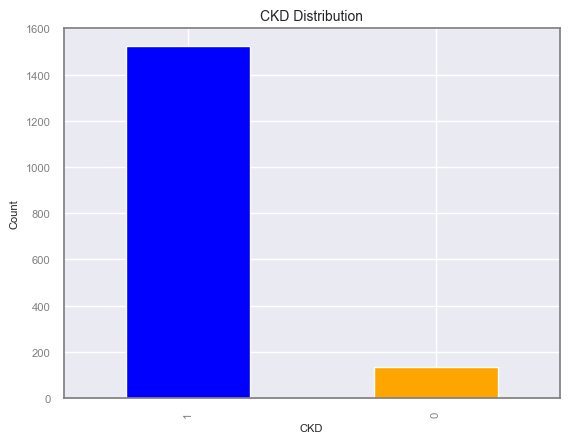

In [231]:
y.value_counts().plot(kind      = 'bar', 
                      title     = 'CKD Distribution', 
                      xlabel    = 'CKD', 
                      ylabel    = 'Count', 
                      color     = ['blue', 'orange']
                      )
plt.show()

### Logistic Regression

In [232]:

# --- 3. Data Splitting: Create the final train/test split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = test_size, random_state = random_state, stratify = y
)
print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}\n")


# --- 4. Manual Feature Scaling (CRITICAL for Logistic Regression) ---

# Initialize scaler
scaler = StandardScaler()

# 4a. Fit scaler ONLY on the numeric columns of the training data
X_train_numeric         = X_train[final_numeric_cols]
X_train_scaled_numeric  = scaler.fit_transform(X_train_numeric)

# 4b. Transform numeric columns of the test data
X_test_numeric          = X_test[final_numeric_cols]
X_test_scaled_numeric   = scaler.transform(X_test_numeric)

# 4c. Combine scaled numeric data with unscaled categorical data for both sets
# Training Set:
X_train_scaled_df   = pd.DataFrame(X_train_scaled_numeric, columns=final_numeric_cols, index=X_train.index)
X_train_final       = pd.concat(
    [X_train_scaled_df, X_train[final_categorical_cols]], axis=1
)

# Test Set:
X_test_scaled_df   = pd.DataFrame(X_test_scaled_numeric, columns=final_numeric_cols, index=X_test.index)
X_test_final       = pd.concat(
    [X_test_scaled_df, X_test[final_categorical_cols]], axis=1
)
print(f"Scaled {len(final_numeric_cols)} numeric features using StandardScaler fit on training data.")


# --- 5. Define Model and Advanced Cross-Validation Strategy ---

# Using Logistic Regression (linear model)
custom_weights = {0: 5, 1: 1} 

# Using Logistic Regression (linear model)
model = LogisticRegression(
    random_state    = random_state, 
    class_weight    = custom_weights, # *** ADJUSTED: Using custom weights for better minority recall ***
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 1.0 # Set C to default 1.0 (less regularization than 0.1)
)
# Define repeated cross-validation strategy: 5 folds repeated 5 times (25 total fits)
N_SPLITS    = 5
N_REPEATS   = 5
print(f"\nDefining Repeated Stratified K-Fold: {N_REPEATS} repeats of {N_SPLITS}-folds ({N_SPLITS * N_REPEATS} total fits)...")

cv = RepeatedStratifiedKFold(
    n_splits        = N_SPLITS,
    n_repeats       = N_REPEATS,
    random_state    = random_state
)

# --- 6. Cross-Validation Evaluation on the SCALED Training Data ---
print("\nPerforming Repeated Stratified Cross-Validation on Training Data...")
cv_scores = cross_val_score(
    model,
    X_train_final, # Use the SCALED training features
    y_train,
    cv      = cv,
    scoring = 'accuracy',
    n_jobs  = -1 # Use all available cores for speed
)

# --- 7. Report CV Results ---
print("--- Repeated Cross-Validation Results (Accuracy) ---")
# print(f"Total {N_SPLITS*N_REPEATS} Individual Scores: {np.round(cv_scores, 4)}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Stdvn: {cv_scores.std():.4f}")

# --- 8. Final Model Training and Evaluation on the Hold-Out Test Set ---

# Train the final model on the entire SCALED training set
print("\nTraining final model on full scaled training set...")
model.fit(X_train_final, y_train)

# Predict on the hold-out scaled test set
y_pred = model.predict(X_test_final)

# Report final test metrics
accuracy    = accuracy_score(y_test, y_pred)
report      = classification_report(y_test, y_pred, target_names=dict_outcome.values())

print(f"Final Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(report)

# --- 9. Feature Importance (Coefficients) ---
print("\n--- Feature Coefficients (Log Odds) ---")

# Combine feature names with their coefficients
feature_names   = X_train_final.columns.tolist()
coefficients    = model.coef_[0]

# Create a DataFrame for easy visualization and sorting
coef_df = pd.DataFrame({
    'Feature':              feature_names,
    'Coefficient':          coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value (highest influence first)
coef_df = coef_df.sort_values(by        = 'Absolute_Coefficient', 
                              ascending = False
                              )

print("Coeffs by absolute magnitude (highest influence first):")
print(coef_df[['Feature', 'Coefficient']].to_string(index=False))


Data Split: Training set size = 1327, Test set size = 332

Scaled 33 numeric features using StandardScaler fit on training data.

Defining Repeated Stratified K-Fold: 5 repeats of 5-folds (25 total fits)...

Performing Repeated Stratified Cross-Validation on Training Data...
--- Repeated Cross-Validation Results (Accuracy) ---
Mean CV Accuracy: 0.8535
Stdvn: 0.0224

Training final model on full scaled training set...
Final Test Accuracy: 0.8283

Classification Report:
              precision    recall  f1-score   support

      CKD_NO       0.23      0.48      0.31        27
     CKD_YES       0.95      0.86      0.90       305

    accuracy                           0.83       332
   macro avg       0.59      0.67      0.61       332
weighted avg       0.89      0.83      0.85       332


--- Feature Coefficients (Log Odds) ---
Coeffs by absolute magnitude (highest influence first):
                      Feature  Coefficient
              SerumCreatinine     0.862176
                 

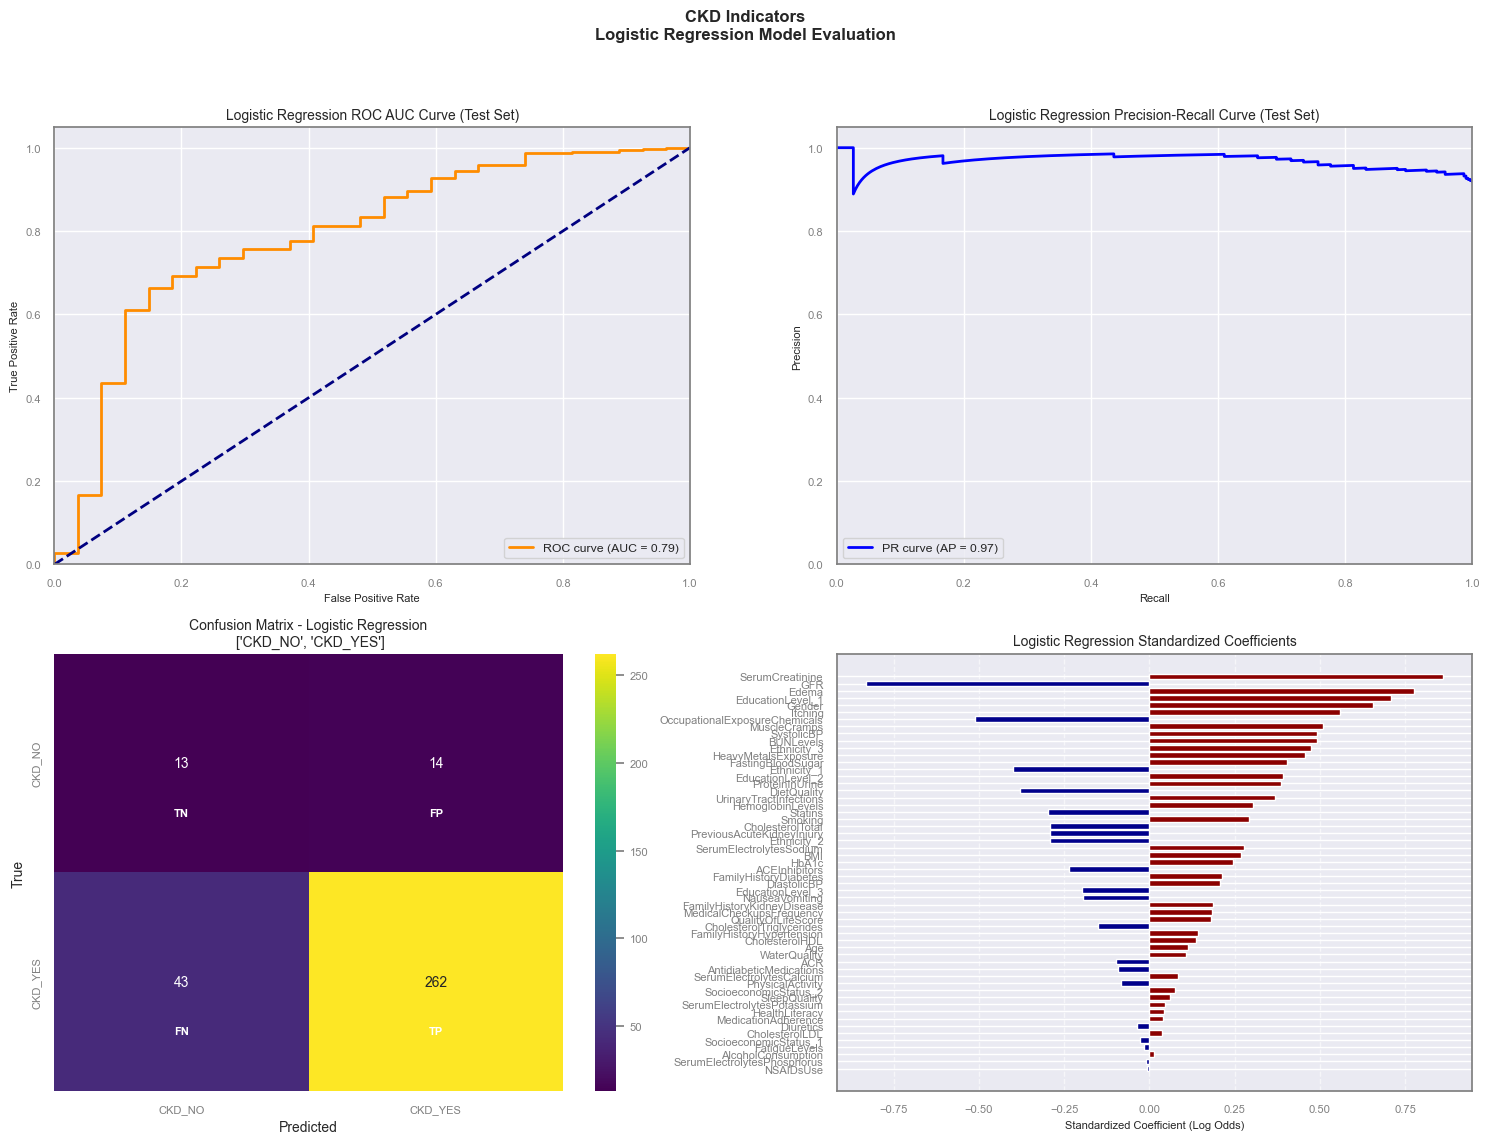

In [233]:
model_name       = "Logistic Regression" # Updated model name
dataset_name     = "CKD Indicators"
labels           = list(dict_outcome.values())

# Create the 2x2 grid
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.flatten()

# Title for the plots
fig.suptitle(f"{dataset_name}\n{model_name} Model Evaluation", fontsize = 12, fontweight = 'bold')

# --- Plot 1: ROC AUC Curve ---
plot_roc_auc_curve(
    model, 
    X_test_final, 
    y_test, 
    title   = f'{model_name} ROC AUC Curve (Test Set)', 
    ax      = ax[0]
)

# --- Plot 2: Precision-Recall Curve ---
plot_precision_recall_curve(
    model, 
    X_test_final, 
    y_test, 
    title   = f'{model_name} Precision-Recall Curve (Test Set)', 
    ax      = ax[1]
)

# --- Plot 3: Confusion Matrix ---
# --- Plot 3: Confusion Matrix ---
plot_confusion_matrix(
    y_test, 
    y_pred, 
    model_name, 
    labels, 
    # title=f'{model_name} Confusion Matrix (Test Set)', 
    ax = ax[2]
)

# --- Plot 4: Feature Importance (Coefficients) ---
plot_feature_importance( 
    model, 
    feature_names = X_train_final.columns, 
    title         = f'{model_name} Standardized Coefficients', 
    ax            = ax[3],
    logistic      = True # Set to True to plot coefficients
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
plt.show()

# Notes


### <font color='gold'>*Why is feature scaling important to models’ performance?*</font>

<font color='plum'>

**1. Ensures Fair Contribution of Features**
Different features may have vastly different ranges (e.g., age from 0–100 vs. income from 0–100,000). Without scaling:
- Models like **linear regression** or **logistic regression** may give undue importance to features with larger values.
- Distance-based models like **K-Nearest Neighbors (KNN)** or **SVM** can be skewed by unscaled features.

 **2. Improves Convergence Speed**
Algorithms like **gradient descent** (used in neural networks and logistic regression) converge faster when features are scaled:
- If features are on similar scales, the optimization landscape is smoother.
- This leads to more stable and faster training.

**3. Necessary for Distance-Based Algorithms**
Models that rely on distance metrics (e.g., Euclidean distance) require scaling:
- **KNN**, **K-Means**, and **SVM** are sensitive to feature magnitudes.
- Without scaling, features with larger ranges dominate the distance calculations.

**4. Enhances Interpretability**
When features are scaled:
- Coefficients in linear models become more interpretable.
- You can better compare the relative importance of features.

 **5. Prevents Numerical Instability**
Large feature values can lead to:
- Overflow or underflow in computations.
- Poor numerical precision, especially in deep learning models.


**Common Scaling Techniques**
- **Standardization**: $$x' = \frac{x - \mu}{\sigma}$$ (mean = 0, std = 1)
- **Min-Max Scaling**: $$x' = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$$ (scaled to [0, 1])
- **Robust Scaling**: Uses median and IQR, good for outliers.




### <font color='gold'>*Why does logistic regression require independent samples?*</font>

<font color='plum'>

Logistic regression requires **independent samples** because the validity of its statistical inference and predictive performance depends on this assumption. 

1. **Statistical Assumptions**. Logistic regression is based on **maximum likelihood estimation (MLE)**, which assumes:
    - Each observation contributes independently to the likelihood function.
    - If samples are dependent (e.g., repeated measures from the same subject), the likelihood is misestimated, leading to **biased coefficients** and **invalid confidence intervals**.

2. **Avoiding Overfitting and Misleading Patterns**. Dependent samples can introduce **artificial patterns**:
    - The model may learn correlations that are due to sample dependency rather than true relationships.
    - This leads to **overfitting**, especially in small datasets.

3. **Valid Model Evaluation** . Most evaluation metrics (accuracy, precision, recall, AUC) assume:
    - Test samples are independent of training samples.
    - If samples are dependent (e.g., time series or clustered data), cross-validation or train-test splits may give **overoptimistic results**.

4. **Misleading Interpretability**. Logistic regression is often used for **interpreting relationships** between predictors and outcomes:
    - If samples are not independent, the estimated effect of a predictor may be **confounded** by the dependency structure.

**What to Do If Samples Aren’t Independent**. If your data violates independence (e.g., repeated measures, clustered data), consider:
- **Mixed-effects logistic regression** (also called hierarchical or multilevel models).
- **Generalized Estimating Equations (GEE)** for correlated observations.
- **Time-series models** if data is sequential.

### <font color='plum'>Difference between standardization and normalization 


| Aspect              | Standardization                  | Normalization                  |
|---------------------|----------------------------------|--------------------------------|
| Output Range        | Mean = 0, Std Dev = 1            | Typically [0, 1]               |
| Sensitive to Outliers | Less sensitive                 | More sensitive                 |
| Best For            | Gaussian-like distributions      | Distance-based models          |
| Formula             | $$\frac{x - \mu}{\sigma}$$       | $$\frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$$ |

**Standardization**
- **Definition**: Transforms data to have a **mean of 0** and a **standard deviation of 1**.
- **Formula**:  


  $$x = \frac{x - \mu}{\sigma}$$  

  where:
   \( \mu \) is the mean of the feature
   \( \sigma \) is the standard deviation

- **Use Case**:
  - Works well with algorithms that assume data is normally distributed (e.g., **logistic regression**, **linear regression**, **SVM**, **neural networks**).
  - Useful when features have different units or scales.

- **Effect**: Centers the data and scales it based on variability.



**Normalization**
- **Definition**: Rescales data to a **fixed range**, typically **[0, 1]**.

  $$x' = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$$

- **Use Case**:
  - Common in **distance-based algorithms** like **KNN**, **K-Means**, and **PCA**.
  - Useful when you want all features to contribute equally to distance calculations.

- **Effect**: Compresses all values into a uniform scale.
